In [127]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline


# Cleaning the Data

In [10]:
data = 'data/dielectron.csv'
df = pd.read_csv(data)
df.head(5)

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,147115,366639895,58.71410,-7.31132,10.531000,-57.29740,12.82020,-2.20267,2.17766,1,11.2836,-1.032340,-1.88066,-11.0778,2.14537,-2.344030,-2.072810,-1,8.94841
1,147115,366704169,6.61188,-4.15213,-0.579855,-5.11278,4.19242,-1.02842,-3.00284,-1,17.1492,-11.713500,5.04474,11.4647,12.75360,0.808077,2.734920,1,15.89300
2,147115,367112316,25.54190,-11.48090,2.041680,22.72460,11.66100,1.42048,2.96560,1,15.8203,-1.472800,2.25895,-15.5888,2.69667,-2.455080,2.148570,1,38.38770
3,147115,366952149,65.39590,7.51214,11.887100,63.86620,14.06190,2.21838,1.00721,1,25.1273,4.087860,2.59641,24.6563,4.84272,2.330210,0.565865,-1,3.72862
4,147115,366523212,61.45040,2.95284,-14.622700,-59.61210,14.91790,-2.09375,-1.37154,-1,13.8871,-0.277757,-2.42560,-13.6708,2.44145,-2.423700,-1.684810,-1,2.74718


In [11]:
df.columns

Index(['Run', 'Event', 'E1', 'px1 ', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1',
       'E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2', 'M'],
      dtype='object')

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99891 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     99891 non-null  int64  
 1   Event   99891 non-null  int64  
 2   E1      99891 non-null  float64
 3   px1     99891 non-null  float64
 4   py1     99891 non-null  float64
 5   pz1     99891 non-null  float64
 6   pt1     99891 non-null  float64
 7   eta1    99891 non-null  float64
 8   phi1    99891 non-null  float64
 9   Q1      99891 non-null  int64  
 10  E2      99891 non-null  float64
 11  px2     99891 non-null  float64
 12  py2     99891 non-null  float64
 13  pz2     99891 non-null  float64
 14  pt2     99891 non-null  float64
 15  eta2    99891 non-null  float64
 16  phi2    99891 non-null  float64
 17  Q2      99891 non-null  int64  
 18  M       99891 non-null  float64
dtypes: float64(15), int64(4)
memory usage: 15.2 MB


In [21]:
# There's an extra space in front of 'px1' lol
df.rename(columns={"px1 ": "px1"}, inplace=True)

/var/folders/54/d7gt67t5397b90wl7j1x39fc0000gn/T/ipykernel_98202/665691069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"px1 ": "px1"}, inplace=True)


In [22]:
df.isnull().sum()

Run      0
Event    0
E1       0
px1      0
py1      0
pz1      0
pt1      0
eta1     0
phi1     0
Q1       0
E2       0
px2      0
py2      0
pz2      0
pt2      0
eta2     0
phi2     0
Q2       0
M        0
dtype: int64

In [14]:
# 85 instances do not have an M value; let's just remove them.
df = df.dropna(subset=['M'])
df.isnull().sum()

Run      0
Event    0
E1       0
px1      0
py1      0
pz1      0
pt1      0
eta1     0
phi1     0
Q1       0
E2       0
px2      0
py2      0
pz2      0
pt2      0
eta2     0
phi2     0
Q2       0
M        0
dtype: int64

In [24]:
df.duplicated().sum()

0

In [23]:
# Drop duplicates
df = df.drop_duplicates(subset=['Event'])
df.duplicated().sum()

0

In [154]:
df.to_csv("data/clean.csv", index=False)

# Data Visualisation

This section will be largely inspired by Danny Bozbay (@danielbozbay), an MSci Theoretical Physics graduate student at Royal Holloway, University of London. His work provided me with the physical insight necessary to make sense of the data. You can find his notebook at https://www.kaggle.com/code/danielbozbay/cern-data-end-to-end-gradient-boosting-0-9-rmse

### Scatter Plots: Numerical Features vs Target

In [59]:
features = list(df.columns)
features.remove('Run')
features.remove('Event')
features.remove('M')

target = 'M'

def scatter_plot(df:pd.DataFrame=df, feature:list[str]=features, target:str=target):
    '''Creates a multiplot of each feature vs. the target'''
    fix, ax = plt.subplots(4, 4, figsize=(22, 16))
    
    counter = 0
    for i in (range(4)):
        for j in (range(4)):
            sns.scatterplot(df, x=feature[counter], y=target, ax=ax[i, j], s=3, alpha=0.1)
            counter += 1


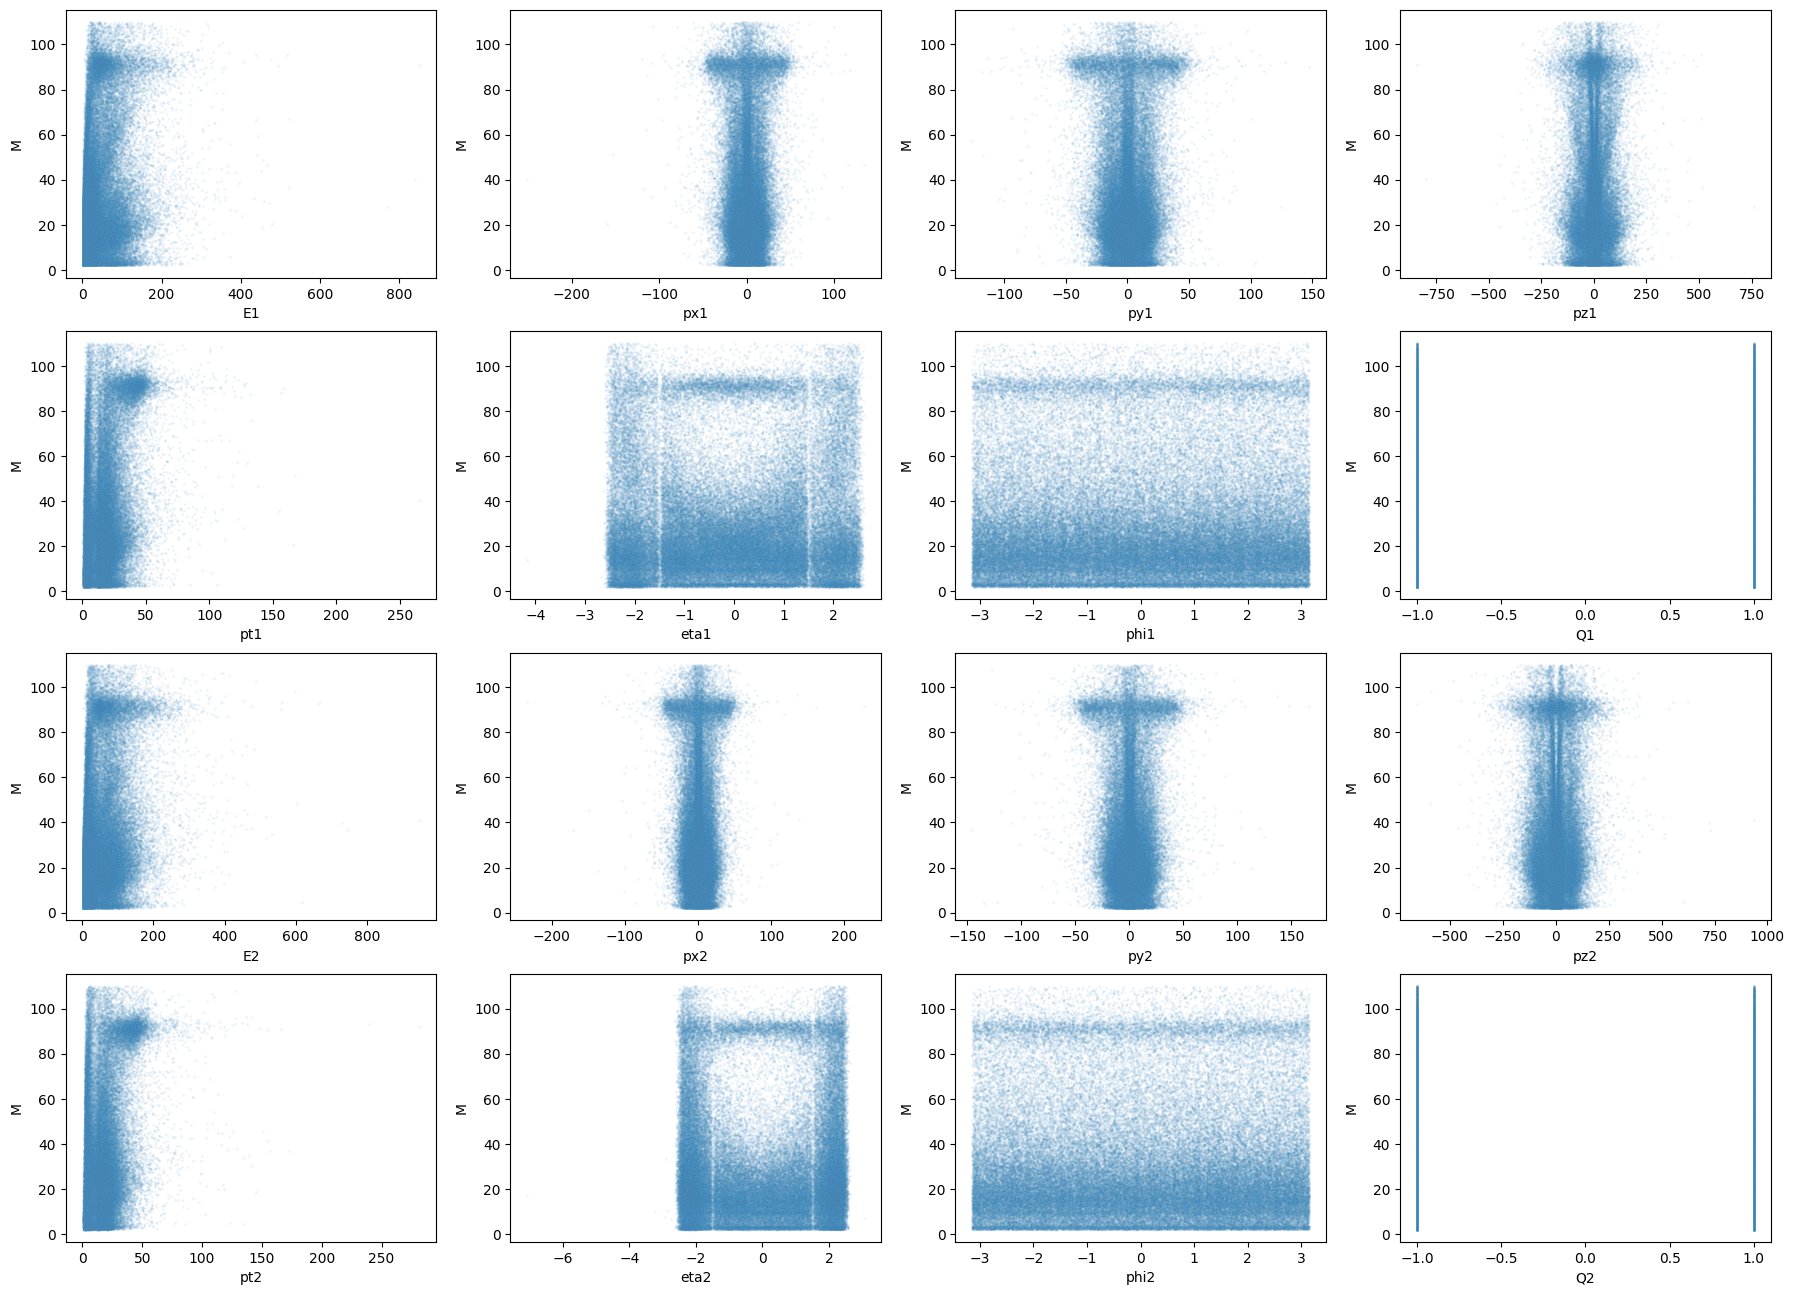

In [60]:
scatter_plot()

### Invariant Mass Distribution

In [91]:
def kde_hist_M(df:pd.DataFrame=df, target:str=target):
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    
    sns.histplot(df[target],bins=50, kde=True, ax=ax)
    
   
    
    plt.title('Distribution of Invariant Mass')
    plt.xlabel('Invariant Mass (GeV)')
    
    plt.annotate("Z", xy=(91, 1720))  # Z boson
    plt.annotate("$J/\\psi$", xy=(2, 6700))  # J/psi meson
    plt.annotate("$Y(1,2,3S)$", xy=(19, 6200))  # Upsilon meson 
    
    plt.grid(alpha=0.75)

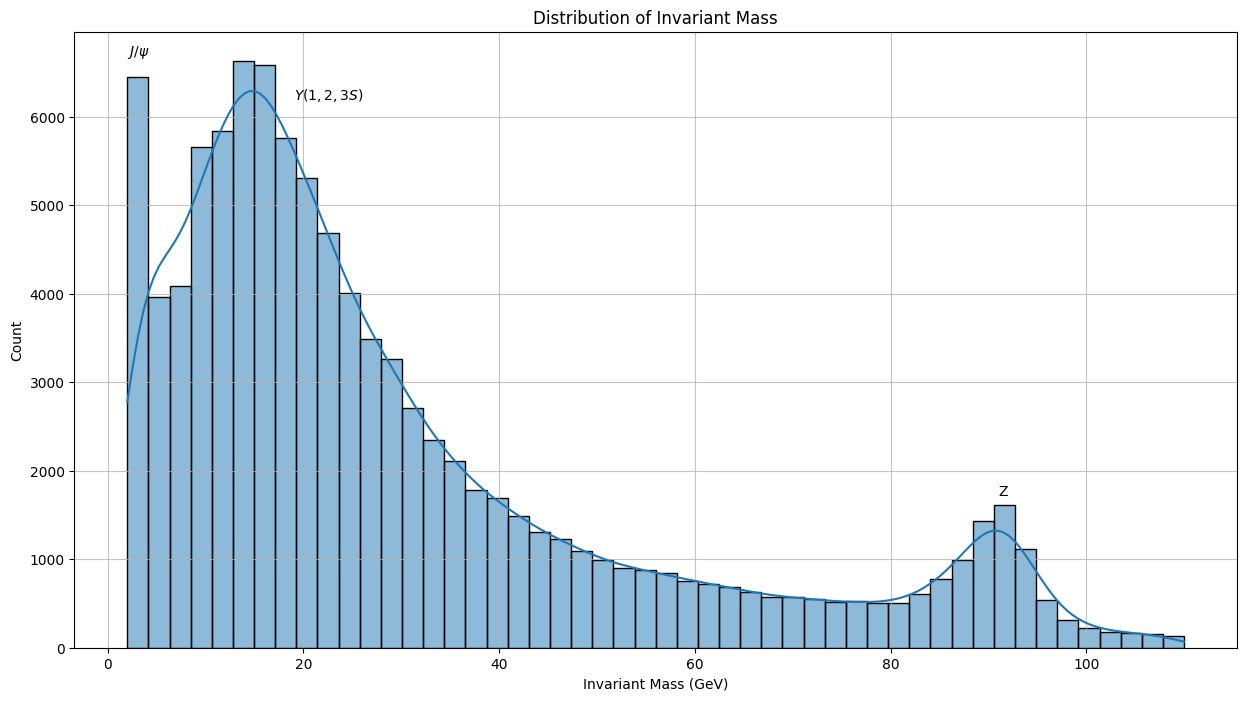

In [92]:
kde_hist_M()

"We see three invarient mass peaks at approximately 3 GeV, 10 GeV and 90 GeV. These peaks represent the J/psi meson, the Y mesons and the Z boson respectively. [...] Invariant mass peaks in a distribution of decay products (e+ and e- in our case) typically represent the mass of a parent particle that decayed to produce those products. When a particle decays, the invariant mass of the resulting decay products will be clustered around the mass of the parent particle. This is because, according to conservation laws, the total energy and momentum before and after the decay must be the same, and the invariant mass is a way to calculate this." - @danielbozbay, on Kaggle 

### Pearson Correlation

In [102]:
def correlation_matrix(df:pd.DataFrame=df, target:str=target,features:list[str]=features, theme:str='white', figsize:tuple=(12, 8)):
    sns.set_theme(style=theme)

    df_numerical = df.select_dtypes(include=np.number)
    df_numerical = df_numerical.drop(['Run', 'Event'], axis=1) # drop identifiers; irrelevant to correlation
    corr = df_numerical.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

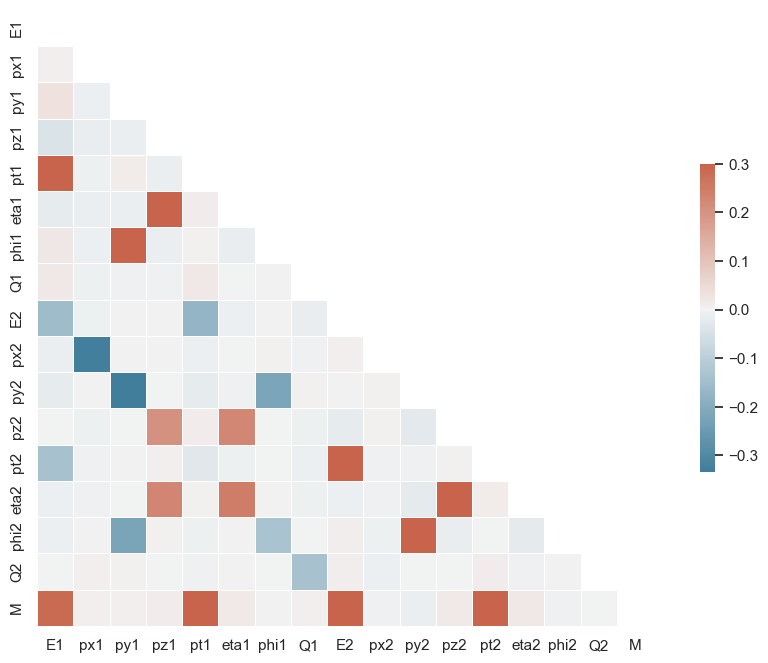

In [103]:
correlation_matrix()

From the correlation matrix, we can quickly see that the features with highest correlation to the invariant mass are E1 (energy of electron 1), pt1 (transverse momentum of electron 1), E2 and pt2 (same features, for the second electron). The transverse momenta and the energies are themeselves highly correlated to one another, which makes sense. 

Another thing worth noting is the inverse correlation between some of the equivalent features of each electron. For example, the second electron momentum along the y-axis is inversely correlated to the first electron's momentum along the same axis. Intuitively, this could be a sign of the particles moving in opposite directions (to be confirmed, I am just hypothesising). In any case, we should be able to exploit these correlations too.

### Outlier Analysis

In [113]:
def box_kde_jointplot(feature:str, df:pd.DataFrame=df):
    '''Plots a box plot over a KDE plot for a specified feature in the dataset.
    credit to @danielbozbay for the code; this is now one of my favourite plots!
    '''
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)}
    )

    # Gridlines
    ax_box.grid(alpha=0.75)
    ax_hist.grid(alpha=0.75)

    # Customizing the flier properties
    flierprops = dict(
        markerfacecolor="r", markersize=2, linestyle="none", markeredgecolor="r"
    )

    # Adding a graph in each part
    sns.boxplot(df[feature], orient="h", ax=ax_box, flierprops=flierprops)
    sns.histplot(df[feature], ax=ax_hist, bins=50, kde=True)

    # Remove x axis name for the boxplot
    ax_box.set(xlabel="")

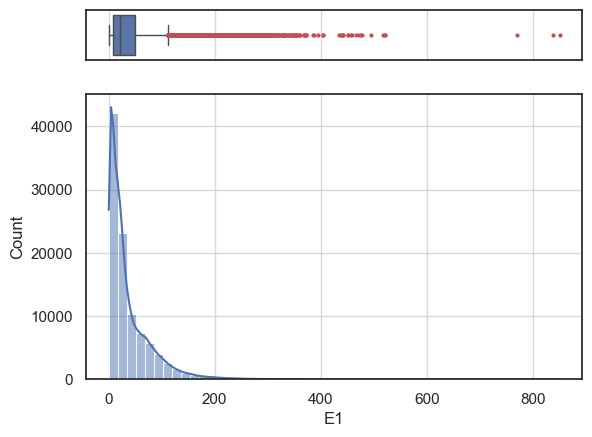

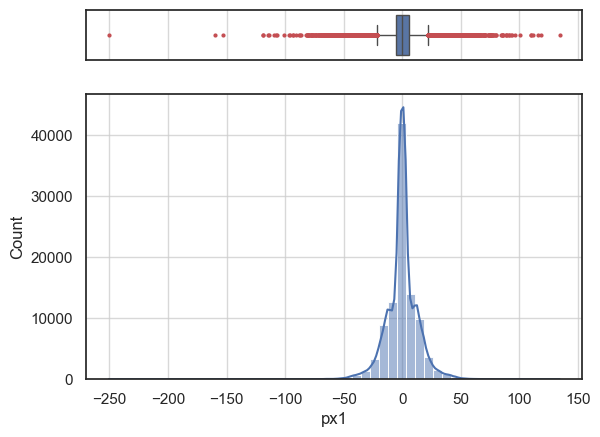

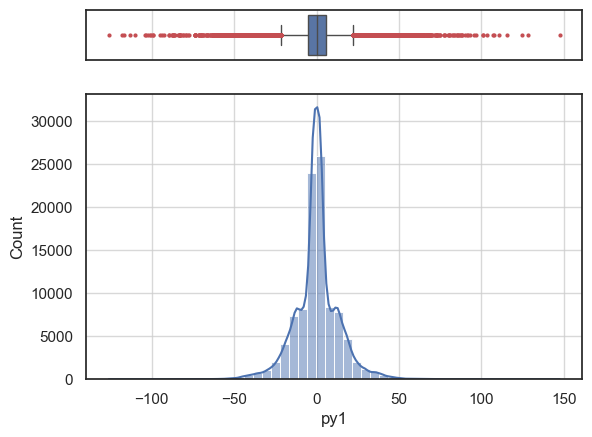

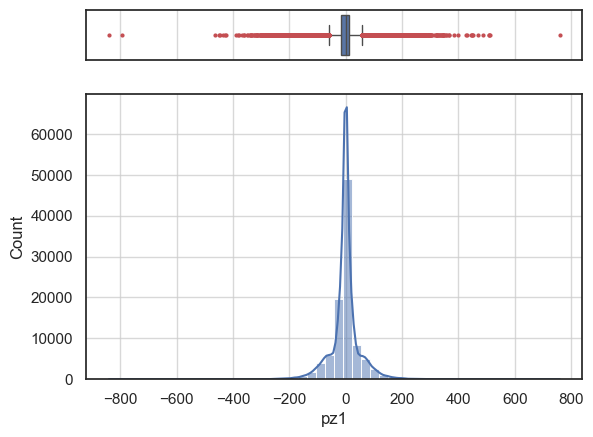

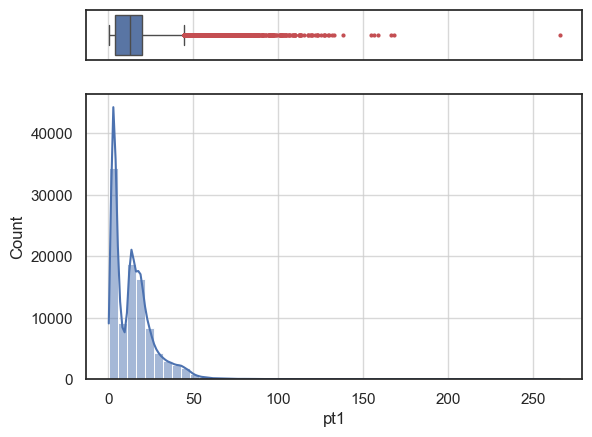

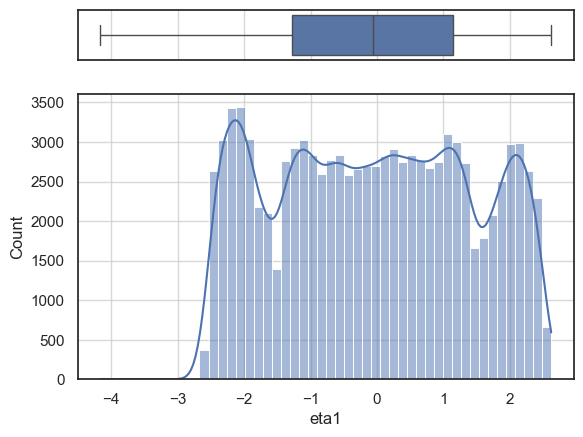

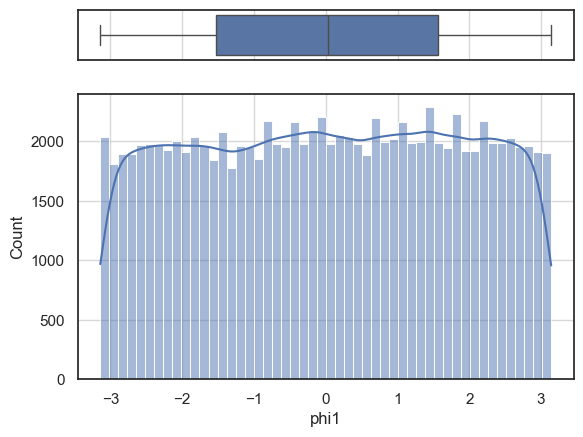

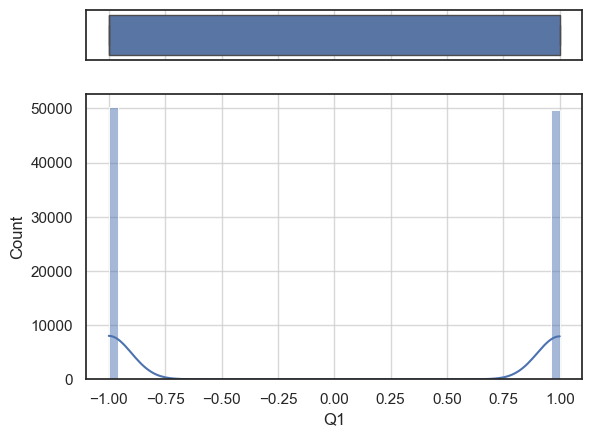

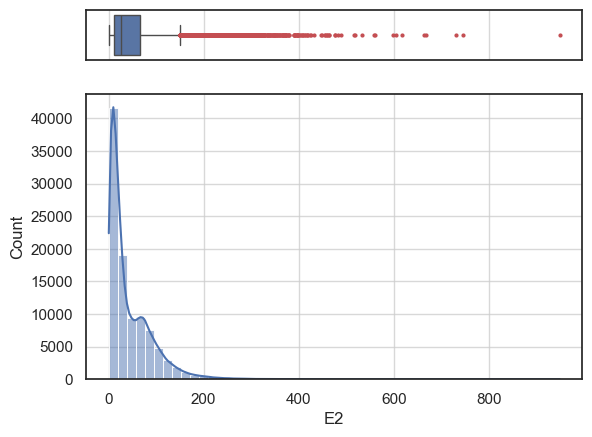

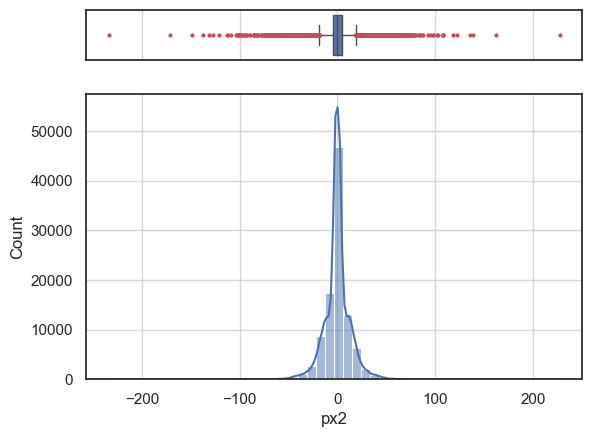

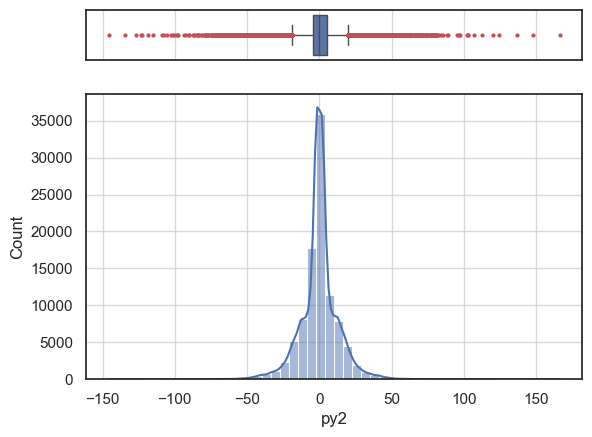

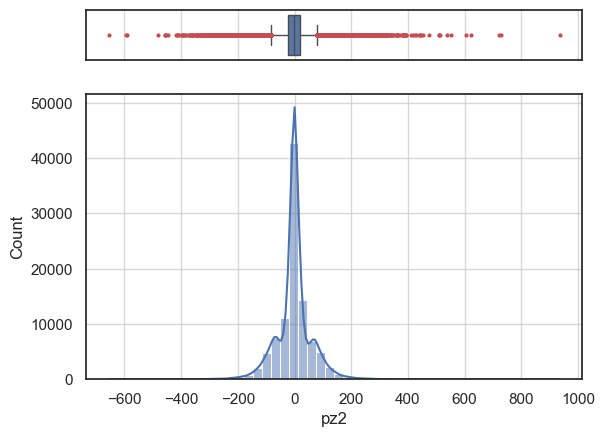

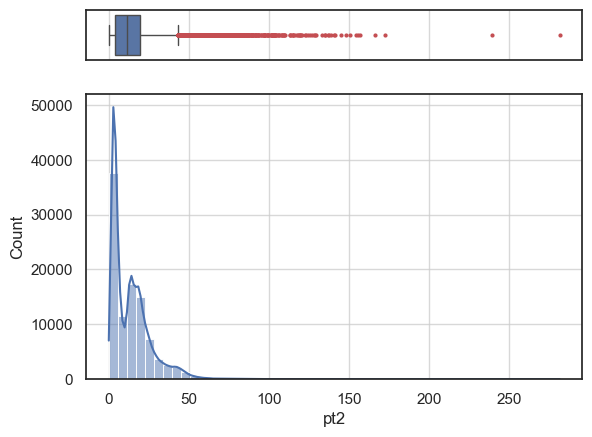

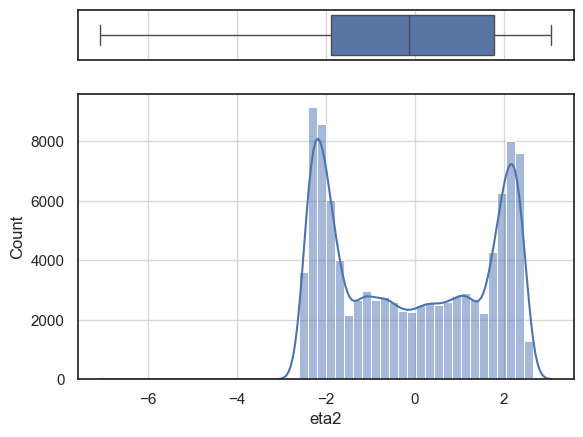

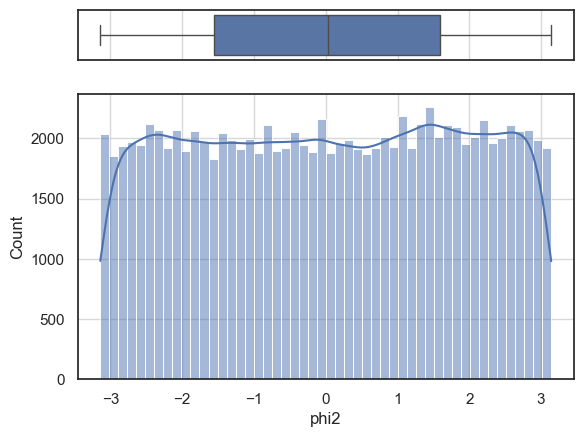

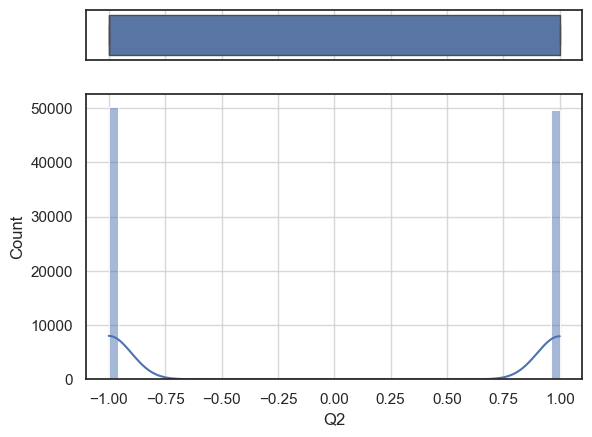

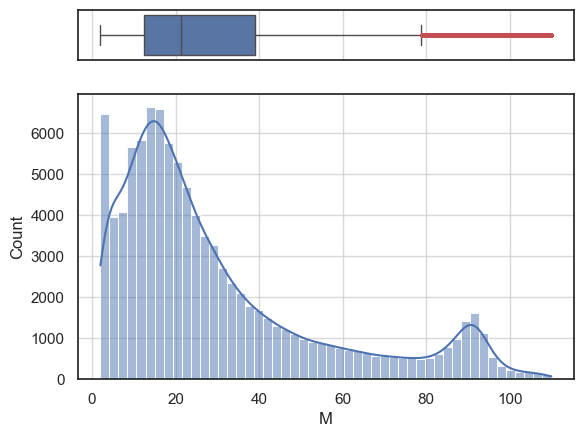

In [116]:
for feature in df.drop(['Run', 'Event'], axis=1).select_dtypes(include=[np.number]).columns:
    box_kde_jointplot(feature)

A number of the features present a substantial percentage of outlier data points; some of the KDE plots are right tail heavy, and others are heavy on both sides even. We will deal with the outlier points in our preprocessing pipeline.

# Preprocessing Pipeline

### Feature Engineering Unit
I want to build upon existing work I've seen by adding Feature Selection, PCA or Clustering to the final model. These are three different methods that aim to do the same thing: reduce the dimensionality of our inputs in order to improve model performance and/or shorten training time. I will experiment with all three and compare the results.

In [128]:
# class FeaturesAdder(BaseEstimator, TransformerMixin):
#     def __init__(self, add_bedrooms_per_room = True): 
#         self.add_bedrooms_per_room = add_bedrooms_per_room

#     def fit(self, X, y=None):
#         return self 
    
#     def transform(self, X, y=None):
#         '''The features we want to add are: 
#             1. Total energy: E1 + E2
#             2. Product of the momenta components: px1 px2, py1 py2, pz1 pz2
#             3. Product of the transverse momenta: pt1 * pt2
#             4. Product of the charges: Q1 * Q2
#             5. Product of the pseudorapidities: phi1 phi2, eta1 eta2
#             See next cell for a discussion.
#         '''
        
#         X = X.copy()
        
#         X['Total Energy'] = X['E1'] + X['E2']
        
#         X['px1px2'] = X['px1'] * X['px2']
#         X['py1py2'] = X['py1'] * X['py2']
#         X['pz1pz2'] = X['pz1'] * X['pz2']
        
#         X['pt1pt2'] = X['pt1'] * X['pt2']
        
#         X['Q1Q2'] = X['Q1'] * X['Q2']
        
#         X['phi1phi2'] = X['phi2'] * X['phi2']
#         X['eta1eta2'] = X['eta2'] * X['eta2']
        
#         return pd.DataFrame(X)

Once again, I thank Danny for his guidance. The explanation he gave regarding the added features is as follow:

"The motivation for creating these features is that 1) The total energy of a system is a conserved quantity in physics. 2) Kinetic energy is proportional to the square of momentum. 3) The product of the charges determines the type of interaction between the particles (attraction or repulsion)."

This is all relatively obvious from a classical mechanics point of view:

1) Simply a statement of conservation of energy.
2) In our system, 

    \begin{equation}
        \text{KE}_{sys} = \frac{1}{2}m\vec{v}^2 + \frac{1}{2}m\vec{v}^2 \rightarrow \text{KE}_{sys} = \frac{1}{2}(p_1\vec{v} + p_2\vec{v})
    \end{equation}
3) Electrons and Positrons attract eachother, whereas identically charged particles repel; the first situation translates to Q1 * Q2 = -1, and the second to Q1 * Q2 = 1

### Outlier Normalization Unit

In [188]:
# Again, credits to Danny; his notebook taught me how to deal with outliers. I am reusing his code here.
# class OutlierImputator(BaseEstimator, TransformerMixin):
#     def __init__(self, n_neighbors=30, contamination=0.005, verbose=False):
#         self.n_neighbors = n_neighbors
#         self.contamination = contamination
#         self.verbose = verbose

#     def outliers_lof(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
#         """Detects outliers -> replaces them with the mean of each feature."""
#         X = X.copy()
        
#         lof = LocalOutlierFactor(
#             n_neighbors=self.n_neighbors, contamination=self.contamination, n_jobs=-1
#         )
        
#         num_features = X.select_dtypes(include=[np.number]).columns # Q1 and Q2 are numerical values, but categories.
#         predictions = lof.fit_predict(num_features)

#         outliers = np.where(predictions == -1)[0]

#         num_outliers = len(outliers)

#         for i in outliers:
#             X.iloc[i][num_features] = X[num_features].mean()

#         if self.verbose:
#             print("-" * 50)
#             print("Outlier Imputation Report")
#             print("-" * 50)
#             print(f"Number of outliers: {num_outliers}")
#             print(f"Percentage of outliers: {num_outliers / X.shape[0] * 100:.2f}%")

#         return pd.DataFrame(X).round(3)

#     def fit(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
#         """Do nothing."""
#         return self

#     def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
#         """Transforms the data by applying and returning the outlier_lof() method."""
#         return self.outliers_lof(X)

### Scaling Unit

In [164]:
# class Scaler(BaseEstimator, TransformerMixin):
#     def __init__(self, standard=True):
#         self.standard = standard
#         self.scaler = None
        
#     def fit(self, X:pd.DataFrame, y=None) -> pd.DataFrame:
#         if self.standard:
#             self.scaler = StandardScaler()
#         else:
#             self.scaler = RobustScaler() # We will be using this in a pipeline where the outliers are left untouched.
#         self.scaler.fit(X)
#         return self

#     def transform(self, X:pd.DataFrame, y=None) -> pd.DataFrame:
#         return pd.DataFrame(self.scaler.transform(X), columns=list(X.columns) + [
#         'Total Energy',
#         'px1px2',
#         'py1py2',
#         'pz1pz2',
#         'pt1pt2',
#         'Q1Q2',
#         'phi1phi2',
#         'eta1eta2'
#     ])

# A Standard Machine Learning Approach

### Data Preparation

In [163]:
cols = df.select_dtypes(include=[np.number]).drop(['Q1', 'Q2'], axis=1).columns
new_attributes = [
        'Total Energy',
        'px1px2',
        'py1py2',
        'pz1pz2',
        'pt1pt2',
        'Q1Q2',
        'phi1phi2',
        'eta1eta2'
    ]

cols = cols.tolist() + new_attributes
cols

['Run',
 'Event',
 'E1',
 'px1',
 'py1',
 'pz1',
 'pt1',
 'eta1',
 'phi1',
 'E2',
 'px2',
 'py2',
 'pz2',
 'pt2',
 'eta2',
 'phi2',
 'M',
 'Total Energy',
 'px1px2',
 'py1py2',
 'pz1pz2',
 'pt1pt2',
 'Q1Q2',
 'phi1phi2',
 'eta1eta2']

In [179]:
def feature_engineer(X:pd.DataFrame) -> pd.DataFrame:
    
    X = X.copy()
    
    X['Total Energy'] = X['E1'] + X['E2']
        
    X['px1px2'] = X['px1'] * X['px2']
    X['py1py2'] = X['py1'] * X['py2']
    X['pz1pz2'] = X['pz1'] * X['pz2']
        
    X['pt1pt2'] = X['pt1'] * X['pt2']
        
    X['Q1Q2'] = X['Q1'] * X['Q2']
        
    X['phi1phi2'] = X['phi2'] * X['phi2']
    X['eta1eta2'] = X['eta2'] * X['eta2']
    
    return X

In [185]:
# from sklearn.compose import ColumnTransformer

# def prep_data(df: pd.DataFrame, standard=True, add_features=True) -> pd.DataFrame:
#     '''Function to prepare our data for the model.'''

#     df_copy = df.drop(['Run', 'Event'], axis=1)
#     new_attributes = []
    
#     if add_features:
#         df_copy = feature_engineer(df_copy)
#         new_attributes = [
#         # 'Total Energy',
#         'px1px2',
#         'py1py2',
#         'pz1pz2',
#         'pt1pt2',
#         'Q1Q2',
#         'phi1phi2',
#         'eta1eta2'
#     ]

#     numerical_attribs = list(df_copy.select_dtypes(include=np.number).columns)
    
#     if standard:     
#         full_pipeline = ColumnTransformer([
#             ('outlier_removal', OutlierImputator(), numerical_attribs),
#             ('scaling', Scaler(standard), numerical_attribs+(new_attributes)),
#         ])
#     else:
#         full_pipeline = ColumnTransformer([
#             ('scaling', Scaler(standard), numerical_attribs+(new_attributes)),
#         ])

#     array_prep = full_pipeline.fit_transform(df_copy)

#     # column names after one-hot encoding
#     new_columns = numerical_attribs + list(new_attributes)

#     df_ready = pd.DataFrame(array_prep, columns=new_columns)
#     return df_ready

In [191]:
def prep_data(df: pd.DataFrame, add_features=True) -> pd.DataFrame:
    '''Function to prepare our data for the model.'''

    df_copy = df.drop(['Run', 'Event'], axis=1)

    if add_features:
      df_copy = feature_engineer(df_copy)

    numerical_attribs = list(df_copy.select_dtypes(include=np.number))
    cat_attribs = list(df_copy.select_dtypes(include=object))

    numerical_pipeline = Pipeline([
      ('std_scaler', RobustScaler()) # using RobustScaler, which is less sensitive to outliers
    ])

    array_prep = numerical_pipeline.fit_transform(df_copy)
    
    df_ready = pd.DataFrame(array_prep, columns=df_copy.columns)
    return df_ready

In [192]:
from sklearn.model_selection import train_test_split

def train_split(df: pd.DataFrame, target:str, add_features=True):
    '''Function to split our data into train and test sets.'''
    prepared_data = prep_data(df, add_features)

    y = df[target]
    X = prepared_data

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return x_train, x_val, y_train, y_val

In [199]:
clean_data = 'data/clean.csv'
df_fresh_extra = pd.read_csv(clean_data)

# 'extra' refers to the addition of engineered features.
X_train_extra, X_val_extra, y_train_extra, y_val_extra = train_split(df_fresh_extra, 'M', add_features=True)

print(f"{X_train_extra.shape}\n{X_val_extra.shape}\n{y_train_extra.shape}\n{y_val_extra.shape}\n")

(79912, 24)
(19979, 24)
(79912,)
(19979,)



In [201]:
df_fresh = pd.read_csv(clean_data)

X_train, X_val, y_train, y_val = train_split(df_fresh_extra, 'M', add_features=False)

print(f"{X_train.shape}\n{X_val.shape}\n{y_train.shape}\n{y_val.shape}\n")

(79912, 17)
(19979, 17)
(79912,)
(19979,)



### Model Building Pipelines

In [ ]:


def build_ensemble(add_features:bool, path_to_data:str, target:str='M'):
    '''Builds an ensemble model and evaluates it using cross-validation.'''
    df = pd.read_csv(path_to_data)
    
    X_train, X_val, y_train, y_val = train_split(df, target, add_features)


### Results

### Analysis

# A Deep Learning Approach

### Pipeline

### Results

### Analysis

# Conclusion